# FastAI Age Classifier

Using FastAI's framework it is pretty easy to create our classifier with just a few lines of code.

In [1]:
from __future__ import print_function, division
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import shutil
import pandas as pd
import numpy as np
import tensorflow as tf
from fastai.vision import *
from fastai.basics import *
from fastai.callbacks import *
from fastai.widgets import ClassConfusion
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip '/content/drive/My Drive/Face_Age_Train_Val_Test2.zip'

### Resize our input images for our model

In [4]:
path = '/content/' # root path
os.mkdir('small-256') # make a directory for storing the resized images
path_mr = '/content/small-256'
path_hr = '/content/Face_Age_Train_Val_Test2'

In [5]:
il = ImageList.from_folder('/content/Face_Age_Train_Val_Test2')

def resize_one(fn, i, path):
  '''
  Resizes the images so that they can all be the same size which is 256x256
  INPUTS: 
  fn - filename of the image
  path - path of the root directory you have your new folders on 
   '''
    dest = path/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    # targ_sz = resize_to(img, (256,256), use_min=True)
    img = img.resize(size=(256,256), resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=75)


parallel(partial(resize_one, path=path_mr), il.items)

### Create list of our data transforms

In [3]:
tfms = get_transforms(max_rotate=15, flip_vert=False, xtra_tfms=[*rand_resize_crop(size=(224),max_scale=1.3)])  # add transforms for data augmentation
tfms # show our data transforms

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-15, 15)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.1), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do_run

In [4]:
data = ImageDataBunch.from_folder('/content/small-256', ds_tfms=tfms, bs = 32) # get the data from the path

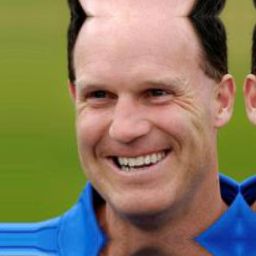

In [5]:
img,label = data.train_ds[0] #example of one of the images
img

In [14]:
data.valid_ds

LabelList (4858 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
40-44,40-44,40-44,40-44,40-44
Path: /content/small-256

In [15]:
data.train_ds

LabelList (27472 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
40-44,40-44,40-44,40-44,40-44
Path: /content/small-256

### Try different pretrained models and compare them by time and accuracy within 3 epochs

In [ ]:
learn = cnn_learner(data, models.vgg16_bn, metrics=accuracy)
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,2.221913,2.063425,0.300947,06:54
1,1.910319,1.867082,0.345615,06:58
2,1.807003,1.789158,0.369082,06:58


In [18]:
# need to reduce batch size to fit to memory
learn = cnn_learner(data, models.resnet50, metrics=accuracy)
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,2.087041,1.910440,0.332853,07:01
1,1.771078,1.669525,0.392137,06:55
2,1.725330,1.617676,0.411280,06:52


In [21]:
learn = cnn_learner(data, models.mobilenet_v2, metrics=accuracy)
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,2.129485,1.902168,0.327089,05:57
1,1.824123,1.691764,0.390696,05:52
2,1.685710,1.629554,0.411486,05:52


Looking at these, we can see that mobilenet_v2 seems the best in terms of both accuracy and time.

### Check optimal learning rate

In [6]:
learn = cnn_learner(data, models.mobilenet_v2, metrics=accuracy)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


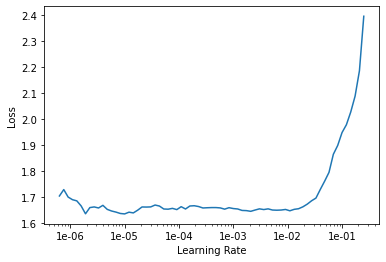

In [7]:
learn.recorder.plot()

Not good, the optimal graph should be horizontally flipped. This shows us that the loss will increase as the learning rate increases.

### Train Model
In this version we will use the fit_one_cycle method which is very effective for leveraging the learning rate. You can read more about it [here](https://sgugger.github.io/the-1cycle-policy.html) We will train on 25 epochs with mobilenet architecture.

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.701702,2.135265,0.295183,0.704817,05:41
1,2.217757,1.937812,0.319267,0.680733,05:42
2,2.005836,1.812455,0.355908,0.644092,05:44
3,1.902357,1.771667,0.371964,0.628036,05:44
4,1.827645,1.689872,0.394401,0.605599,05:39
5,1.756637,1.648840,0.397077,0.602923,05:39
6,1.714305,1.627004,0.400165,0.599835,05:40
7,1.666187,1.571547,0.419514,0.580486,05:42
8,1.624806,1.517892,0.444010,0.555990,05:41
9,1.561736,1.524150,0.433306,0.566694,05:40


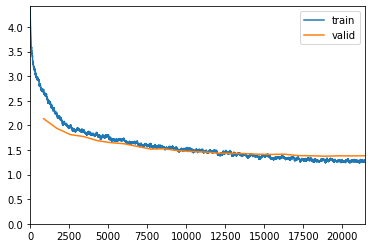

Better model found at epoch 0 with accuracy value: 0.2951832115650177.
Better model found at epoch 1 with accuracy value: 0.3192671835422516.
Better model found at epoch 2 with accuracy value: 0.35590776801109314.
Better model found at epoch 3 with accuracy value: 0.371963769197464.
Better model found at epoch 4 with accuracy value: 0.3944009840488434.
Better model found at epoch 5 with accuracy value: 0.3970769941806793.
Better model found at epoch 6 with accuracy value: 0.4001646637916565.
Better model found at epoch 7 with accuracy value: 0.4195142090320587.
Better model found at epoch 8 with accuracy value: 0.4440098702907562.
Better model found at epoch 11 with accuracy value: 0.4497735798358917.
Better model found at epoch 13 with accuracy value: 0.4621243178844452.
Better model found at epoch 14 with accuracy value: 0.46356526017189026.
Better model found at epoch 16 with accuracy value: 0.46500617265701294.
Better model found at epoch 17 with accuracy value: 0.4678880274295807.

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe2740a58d0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe2740a58d0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/usr/local/l

Better model found at epoch 24 with accuracy value: 0.4827089309692383.


In [9]:
learn = cnn_learner(data, models.mobilenet_v2, metrics=[accuracy, error_rate])
learn.fit_one_cycle(25,callbacks=[ShowGraph(learn),SaveModelCallback(learn, every='improvement', monitor='accuracy')])

It's possible that with more epochs, the model would become more accurate but it trains very slowly because there isn't an optimal learning rate.

In [11]:
learn.export()

### Evaluate model

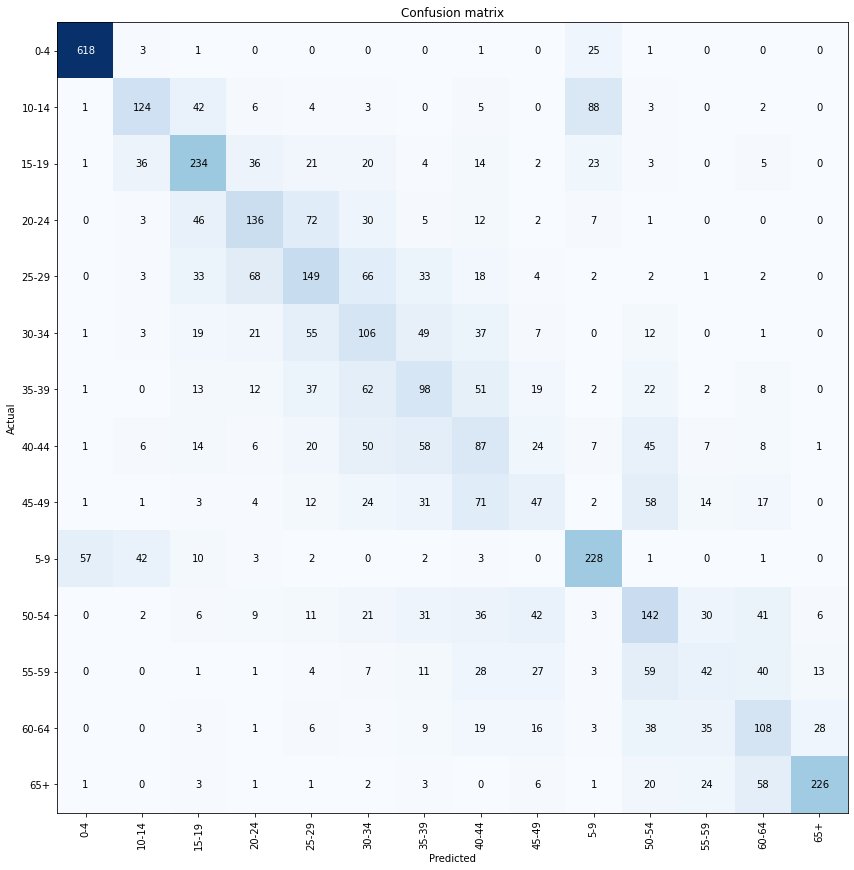

In [10]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12))

We can see that our model does pretty well. If the image isn't correctly classified then it's most likely predicted to be a close age group to the actual class. Note that the 5-9 group is not in correct order.

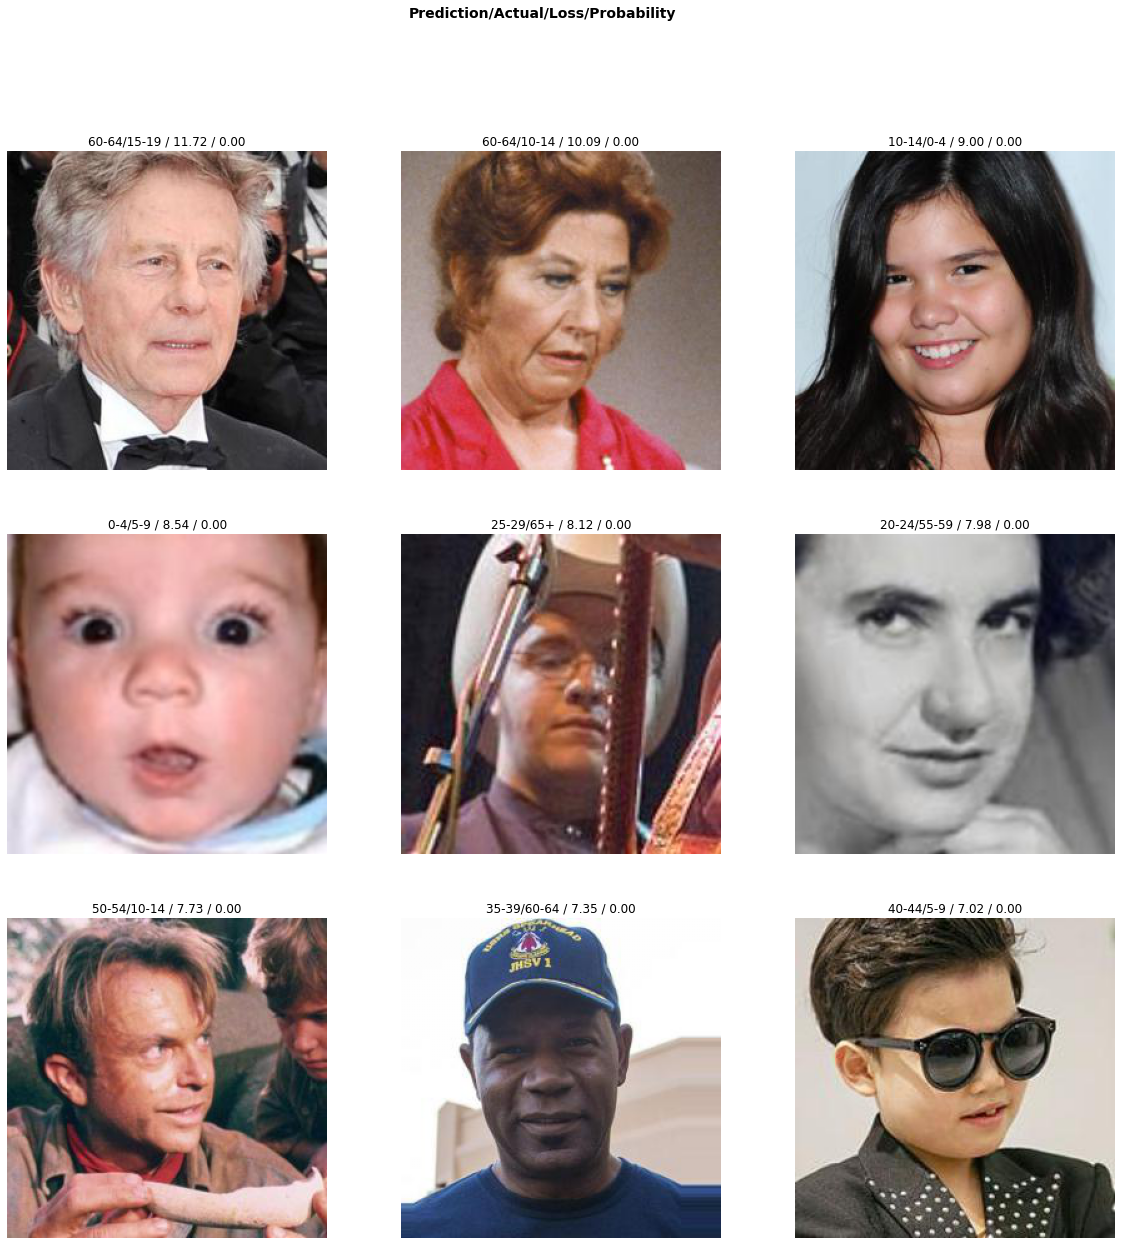

In [12]:
interp.plot_top_losses(9, figsize=(20,20))

These are the images that had the least probability for the actual class. You can see that the actual class is incorrect for some of the cases.

In [ ]:
# classlist = ['0-4', '5-9', '10-14', '15-19']
# ClassConfusion(interp, classlist, is_ordered=False, figsize=(8,8));